# Running SGP4 to calculate and plot Fermi beta angle

### <span style="color:red; font-family:Georgia;">Robert Cameron, July 2015</span>

Based on the python implementation of SGP4 orbit propagator
available at https://pypi.python.org/pypi/sgp4/

In [1]:
# specify the date range limits to calculate the beta angle for Fermi
start = "2015-07-01" 
stop = "2016-07-01"

In [2]:
import numpy as np
from IPython.html.widgets import *
from IPython.display import *
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('figure', figsize = [12, 8])
plt.rc('font', size = 16)
import sys
sys.path.append('/Users/rc/Documents/GLAST/sgp4-1.4')
from sgp4.earth_gravity import wgs84
from sgp4.io import twoline2rv
from sgp4.ext import jday, invjday, days2mdhms
import datetime as dt     
today = str(dt.date.today())

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
tle = !tail -2 /Users/rc/Documents/GLAST/FGST-TLE.txt

In [4]:
tle

['1 33053U 08029A   15245.03050821  .00001036  00000-0  44426-4 0  9993',
 '2 33053  25.5828 133.4046 0012407 279.4054  80.5078 15.10078745398299']

In [5]:
satellite = twoline2rv(tle[0], tle[1], wgs84)

In [6]:
(y0,m0,d0) = map(int, start.split("-"))
jd0 = jday(y0,m0,d0,0,0,0)
doy0 = jd0 - jday(y0,1,1,0,0,0)
(y1,m1,d1) = map(int, stop.split("-"))
ndays = int(jday(y1,m1,d1,0,0,0)  - jd0)
(y0, doy0, ndays)

(2015, 181.0, 366)

In [7]:
oformat = "%4d %02d %02d %02d %02d %02d %12.5f %12.6f %12.6f %12.6f %8.3f\n"
fo = open("beta_"+today+".txt", "w")
fdoypl = []
betapl = []
for day in range(ndays):
    for hour in range(24):
# add a small amount to the day number to ensure it is always a fraction of a second past the hour
        dinc = day + hour/24.0 + 1.0e-9
        jd = jd0 + dinc
        fdoy = doy0 + dinc
        (y,mon,d,h,m,s) = invjday(jd)    # need jd for the sun ephemeris
        s = int(s)
        fdoypl.append(fdoy)
        pos, vel = satellite.propagate(y,mon,d,h,m,s)  # this is the key line to specify the date
        pole = np.cross(pos,vel)
        polelen = np.linalg.norm(pole)
# calculate sun coordinates
        n = jd - 2451545.0
        L = (280.460 + 0.9856474 * n) % 360
        g = np.radians((357.528 + 0.9856003 * n) % 360)
        lamda = np.radians(L + 1.915 * np.sin(g) + 0.020 * np.sin(2*g))
        epsilon = np.radians(23.439 - 0.0000004 * n)
        Xsun = np.cos(lamda)
        Ysun = np.cos(epsilon) * np.sin(lamda)
        Zsun = np.sin(epsilon) * np.sin(lamda)
        dotprod = np.dot([Xsun,Ysun,Zsun], pole)
        beta = np.degrees(np.arcsin(dotprod/polelen))
        betapl.append(beta)
        fo.write(oformat % (y, mon, d, h, m, s, fdoy, pos[0], pos[1], pos[2], beta))
fo.close()

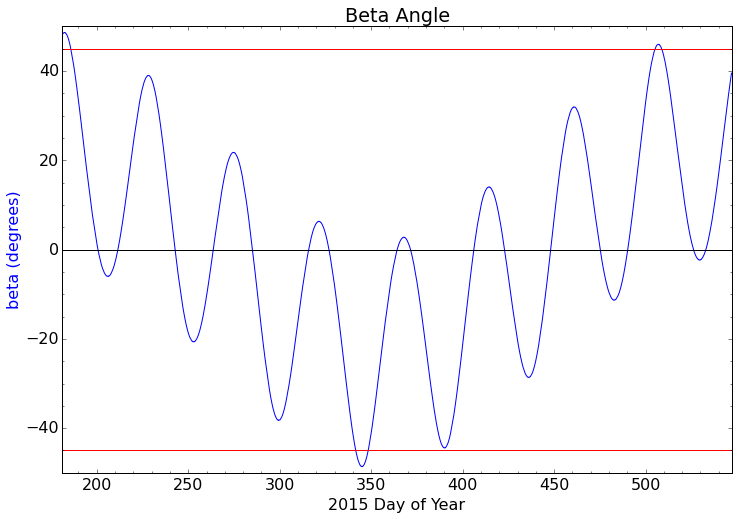

In [8]:
plt.ylim(-50, 50)
plt.xlim(doy0, doy0+ndays)
plt.minorticks_on()
plt.xlabel(str(y0)+' Day of Year')
plt.ylabel('beta (degrees)', color='b')
plt.title("Beta Angle")
plt.plot(fdoypl, betapl, label = 'Beta angle')
plt.plot([fdoypl[0],fdoypl[-1]],[0,0],'k')
plt.plot([fdoypl[0],fdoypl[-1]],[45,45],'r')
plt.plot([fdoypl[0],fdoypl[-1]],[-45,-45],'r')


## Below is an interactive version of the plot, where you can slide the vertical cursor, to get the beta angle value at any DoY and hour of the day (HoD)

The values of the DoY, HoD and corresponding beta angle for the cursor position are show below the plot.

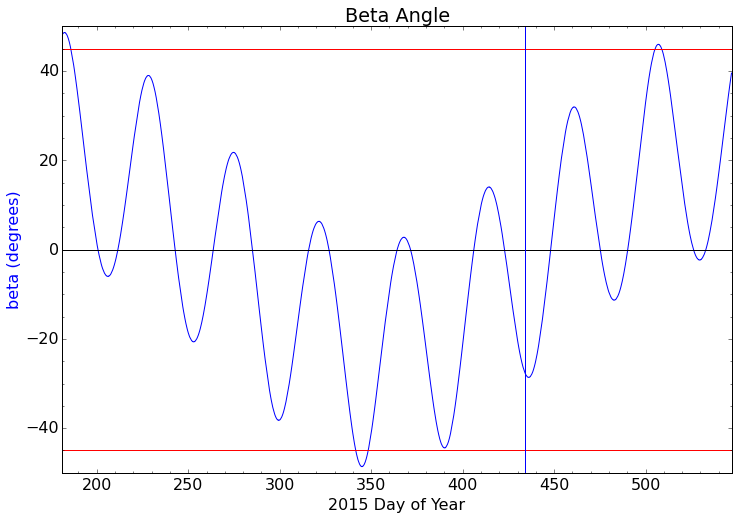

DoY = 434, HoD = 3, Beta angle (deg) = -27.683


In [9]:
fig, ax = plt.subplots()

plt.ylim(-50, 50)
plt.xlim(doy0, doy0+ndays)
plt.minorticks_on()
plt.xlabel(str(y0)+' Day of Year')
plt.ylabel('beta (degrees)', color='b')
plt.title("Beta Angle")
ax.plot(fdoypl, betapl, label = 'Beta angle')
ax.plot([fdoypl[0],fdoypl[-1]],[0,0],'k')
ax.plot([fdoypl[0],fdoypl[-1]],[45,45],'r')
ax.plot([fdoypl[0],fdoypl[-1]],[-45,-45],'r')
plt.close(fig)

vline = ax.axvline(1)

def get_val(idx):
    xx = fdoypl[idx]
    didx = int(xx)
    hidx = xx*24 % 24
    betaidx = betapl[idx]
    vline.set_xdata((xx, xx))
    display(fig)
    print ("DoY = %d, HoD = %d, Beta angle (deg) = %.3f" % (didx, hidx, betaidx))

interactive(get_val, idx=(0, ndays*24-1))